## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import pandas as pd
import numpy as np
import csv 
import matplotlib.pyplot as plt

#just loading the data

data=pd.read_csv('data_000637.txt')
data



,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


In [3]:
data.shape

(1310720, 6)

In [4]:
# NUMBER (1): Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset.

data.head(np.random.randint(10000,1310720 ))


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1198046,1,0,54,3869210423,201,14
1198047,1,0,139,3869210423,205,0
1198048,1,1,53,3869210423,207,9
1198049,1,0,36,3869210423,206,1


In [21]:
# NUMBER (2) : Find out the number of BX in a ORBIT 

#as counting started from 0 so I put +1 to the max of BX_COUNTER
number_of_x=max(data['BX_COUNTER'])+1
number_of_x2 =data['BX_COUNTER'].sum()
number_of_x
 

3564

In [22]:
# NUMBER (3) : Find out how much the data taking lasted.

t_orbits = (np.max(data['ORBIT_CNT'])-np.min(data['ORBIT_CNT']))*25*10**(-9)*number_of_x

data_max = data[data['ORBIT_CNT'] == np.max(data['ORBIT_CNT'])]
data_min = data[data['ORBIT_CNT'] == np.min(data['ORBIT_CNT'])]

t_bx = (np.max(data_max['BX_COUNTER'])-np.min(data_min['BX_COUNTER']))*25*10**(-9)

data_max1 = data_max[data_max['BX_COUNTER'] == np.max(data_max['BX_COUNTER'])]
data_min1 = data_min[data_min['BX_COUNTER'] == np.min(data_min['BX_COUNTER'])]

t_meas = (np.max(data_max1['TDC_MEAS'])-np.min(data_min1['TDC_MEAS']))*25*10**(-9)/30

time = t_orbits+t_bx+t_meas
print('The data taking lasted {} s'.format(time)) 

The data taking lasted 0.9804162533333335 s


In [14]:
# NUMBER(4): Create a new column with the absolute time in ns .
data['CombTime'] =  data['TDC_MEAS'] *25/30 + (data['ORBIT_CNT']*number_of_x +  data['BX_COUNTER']) *25
data.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,CombTime
0,0,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14


In [11]:
# NUMBER(5) : Replace the values (all 1) of the HEAD column randomly with 0 or 1

import random
data['HEAD']=np.random.randint(2,size=1310720)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,CombTime
0,0,0,123,3869200167,2374,26,2497
1,1,0,124,3869200167,2374,27,2498
2,1,0,63,3869200167,2553,28,2616
3,1,0,64,3869200167,2558,19,2622
4,1,0,64,3869200167,2760,25,2824
...,...,...,...,...,...,...,...
1310715,0,0,62,3869211171,762,14,824
1310716,0,1,4,3869211171,763,11,767
1310717,1,0,64,3869211171,764,0,828
1310718,0,0,139,3869211171,769,0,908


In [79]:
# NUMBER(6) : Create a new DataFrame that contains only the rows with HEAD=1

new_data=data[data['HEAD'] == 1]
new_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
2,1,0,63,3869200167,2553,28
5,1,0,63,3869200167,2762,4
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
...,...,...,...,...,...,...
1310711,1,1,39,3869211171,430,0
1310712,1,1,35,3869211171,429,4
1310714,1,0,60,3869211171,762,2
1310716,1,1,4,3869211171,763,11


<Figure size 432x288 with 0 Axes>

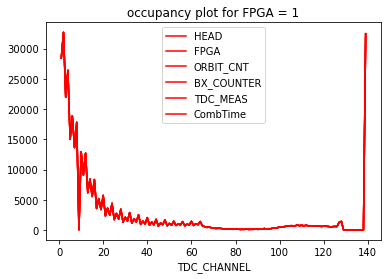

<Figure size 432x288 with 0 Axes>

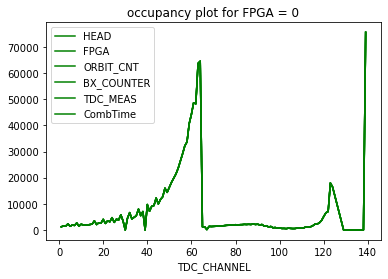

<Figure size 432x288 with 0 Axes>

In [17]:
# NUMBER(7) : Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

first_FPGA=data[data['FPGA'] == 1]
second_FPGA=data[data['FPGA'] == 0]

plot_first_FPGA = first_FPGA.groupby('TDC_CHANNEL').count()
plot_second_FPGA = second_FPGA.groupby('TDC_CHANNEL').count()
 
plot_first_FPGA.plot(c='r')
plt.title('occupancy plot for FPGA = 1')
plt.figure( )
plot_second_FPGA.plot(c='g')
plt.title('occupancy plot for FPGA = 0')
plt.figure( )

In [81]:
# NUMBER(8) :  Use the groupby method to find out the noisy channels

noisy_channels_first=first_FPGA.groupby('TDC_CHANNEL').count()
noisy_channels_second=second_FPGA.groupby('TDC_CHANNEL').count()

print("noisy channels for FPGA=1 :",'\n',noisy_channels_first['HEAD'].nlargest(3),'\n')

print("noisy channels for FPGA=0 :",'\n',noisy_channels_second['HEAD'].nlargest(3))
 

noisy channels for FPGA=1 : 
 TDC_CHANNEL
2      32669
139    32442
1      28438
Name: HEAD, dtype: int64 

noisy channels for FPGA=0 : 
 TDC_CHANNEL
139    75617
64     64581
63     63724
Name: HEAD, dtype: int64


In [89]:
# NUMBER(9) :  Count the number of unique orbit

unique_orbits=data[data['TDC_CHANNEL'] == 139]
print('number of unique orbits with at least one measurement from TDC_CHANNEL=139:',len(np.unique(unique_orbits['ORBIT_CNT'])),'\n')

data[data['TDC_CHANNEL'] == 139].nunique()  

number of unique orbits with at least one measurement from TDC_CHANNEL=139: 10976 



HEAD               2
FPGA               2
TDC_CHANNEL        1
ORBIT_CNT      10976
BX_COUNTER      3564
TDC_MEAS           1
dtype: int64

In [66]:
data.groupby(['TDC_CHANNEL', 'ORBIT_CNT']).count()

HEAD  FPGA  BX_COUNTER  TDC_MEAS
TDC_CHANNEL ORBIT_CNT                                   
1           3869200168     5     5           5         5
            3869200169     5     5           5         5
            3869200170     2     2           2         2
            3869200171     3     3           3         3
            3869200172     2     2           2         2
...                      ...   ...         ...       ...
139         3869211167    19    19          19        19
            3869211168     8     8           8         8
            3869211169    13    13          13        13
            3869211170    12    12          12        12
            3869211171     2     2           2         2

[563084 rows x 4 columns]